In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import folium
import imageio
from tqdm import tqdm_notebook
from folium.plugins import MarkerCluster
import geopy
import geopandas as gpd
import imageio
import mapclassify as mc
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import scipy
from itertools import product
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (12, 10) 
plt.rcParams['axes.grid']=True
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']
data = pd.read_csv('GlobalLandTemperaturesByMajorCity.csv')
data = data.dropna()

In [6]:
data

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W
...,...,...,...,...,...,...,...
239171,4/1/2013,12.563,1.823,Xian,China,34.56N,108.97E
239172,5/1/2013,18.979,0.807,Xian,China,34.56N,108.97E
239173,6/1/2013,23.522,0.647,Xian,China,34.56N,108.97E
239174,7/1/2013,25.251,1.042,Xian,China,34.56N,108.97E


In [8]:
from geopy.geocoders import Nominatim
city_data = data.drop_duplicates(['City'])
city_data.head()
LAT = []
LONG = []
for city in city_data.City.tolist():
    locator = Nominatim(user_agent="myGeocoder")
    location = locator.geocode(city)
    LAT.append(location.latitude)
    LONG.append(location.longitude)

In [9]:
LATCopy = LAT
LONGCopy = LONG

In [10]:
city_data['Latitude'] = LAT
city_data['Longitude'] = LONG

In [11]:
world_map= folium.Map()
geolocator = Nominatim(user_agent="Piero")
marker_cluster = MarkerCluster().add_to(world_map)

In [12]:
for i in range(len(city_data)):
        lat = city_data.iloc[i]['Latitude']
        long = city_data.iloc[i]['Longitude']
        radius=5
        folium.CircleMarker(location = [lat, long], radius=radius,fill =True, color='darkred',fill_color='darkred').add_to(marker_cluster)


In [13]:
world_map

In [29]:
chicago_data = data[data['City']=='Chicago']
chicago_data['AverageTemperature']=chicago_data.AverageTemperature.fillna(method='bfill')

In [47]:
chicago_data = chicago_data.reset_index()
chicago_data = chicago_data.drop(columns=['index'])
chicago_data.dt = pd.to_datetime(chicago_data.dt)
YEAR = []
MONTH = []
DAY = []
WEEKDAY = []
for i in range(len(chicago_data)):
    WEEKDAY.append(chicago_data.dt[i].weekday())
    DAY.append(chicago_data.dt[i].day)
    MONTH.append(chicago_data.dt[i].month)
    YEAR.append(chicago_data.dt[i].year)

In [48]:
chicago_data['Year'] = YEAR
chicago_data['Month'] = MONTH
chicago_data['Day'] = DAY 
chicago_data['Weekday'] = WEEKDAY
change_year_index = []
change_year = []
year_list = chicago_data['Year'].tolist()

In [49]:
for y in range(0,len(year_list)-1):
    if year_list[y]!=year_list[y+1]:
        change_year.append(year_list[y+1])
        change_year_index.append(y+1)
chicago_data.loc[change_year_index].head()
x_ticks_year_list=np.linspace(min(year_list),max(year_list),10).astype(int)
change_year_index = np.array(change_year_index)
x_ticks_year_index = []

Text(0, 0.5, 'Average Temperature')

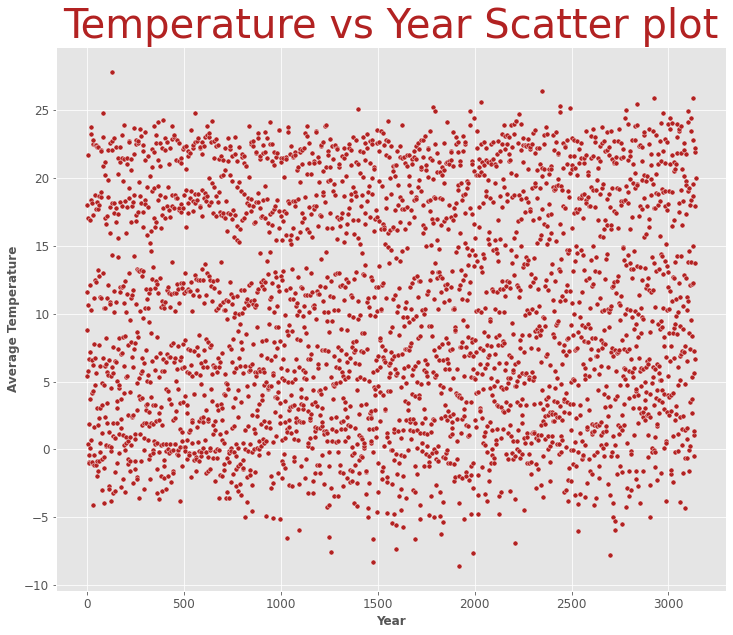

In [50]:
for i in range(1,len(x_ticks_year_list)):
    x_ticks_year_index.append(change_year_index[np.where(np.array(change_year)==x_ticks_year_list[i])][0])
sns.scatterplot(x=chicago_data.index,y=chicago_data.AverageTemperature,s=25,color='firebrick')
plt.title('Temperature vs Year Scatter plot',color='firebrick',fontsize=40)
plt.xlabel('Year')
plt.ylabel('Average Temperature')


In [51]:
last_year_data = chicago_data[chicago_data.Year>=2010].reset_index().drop(columns=['index'])
P = np.linspace(0,len(last_year_data)-1,5).astype(int)
def get_timeseries(start_year,end_year):
    last_year_data = chicago_data[(chicago_data.Year>=start_year) & (chicago_data.Year<=end_year)].reset_index().drop(columns=['index'])
    return last_year_data

In [52]:
def plot_timeseries(start_year,end_year):
    last_year_data = get_timeseries(start_year,end_year)
    P = np.linspace(0,len(last_year_data)-1,5).astype(int)
    plt.plot(last_year_data.AverageTemperature,marker='.',color='firebrick')
    plt.xticks(np.arange(0,len(last_year_data),1)[P],last_year_data.dt.loc[P],rotation=60)
    plt.xlabel('Date (Y/M/D)')
    plt.ylabel('Average Temperature')

In [53]:
def plot_from_data(data,time,c='firebrick',with_ticks=True,label=None):
    time = time.tolist()
    data = np.array(data.tolist())
    P = np.linspace(0,len(data)-1,5).astype(int)
    time = np.array(time)
    if label==None:
        plt.plot(data,marker='.',color=c)
    else:
        plt.plot(data,marker='.',color=c,label=label)
    if with_ticks==True:
        plt.xticks(np.arange(0,len(data),1)[P],time[P],rotation=60)
    plt.xlabel('Date (Y/M/D)')
    plt.ylabel('Average Temperature')

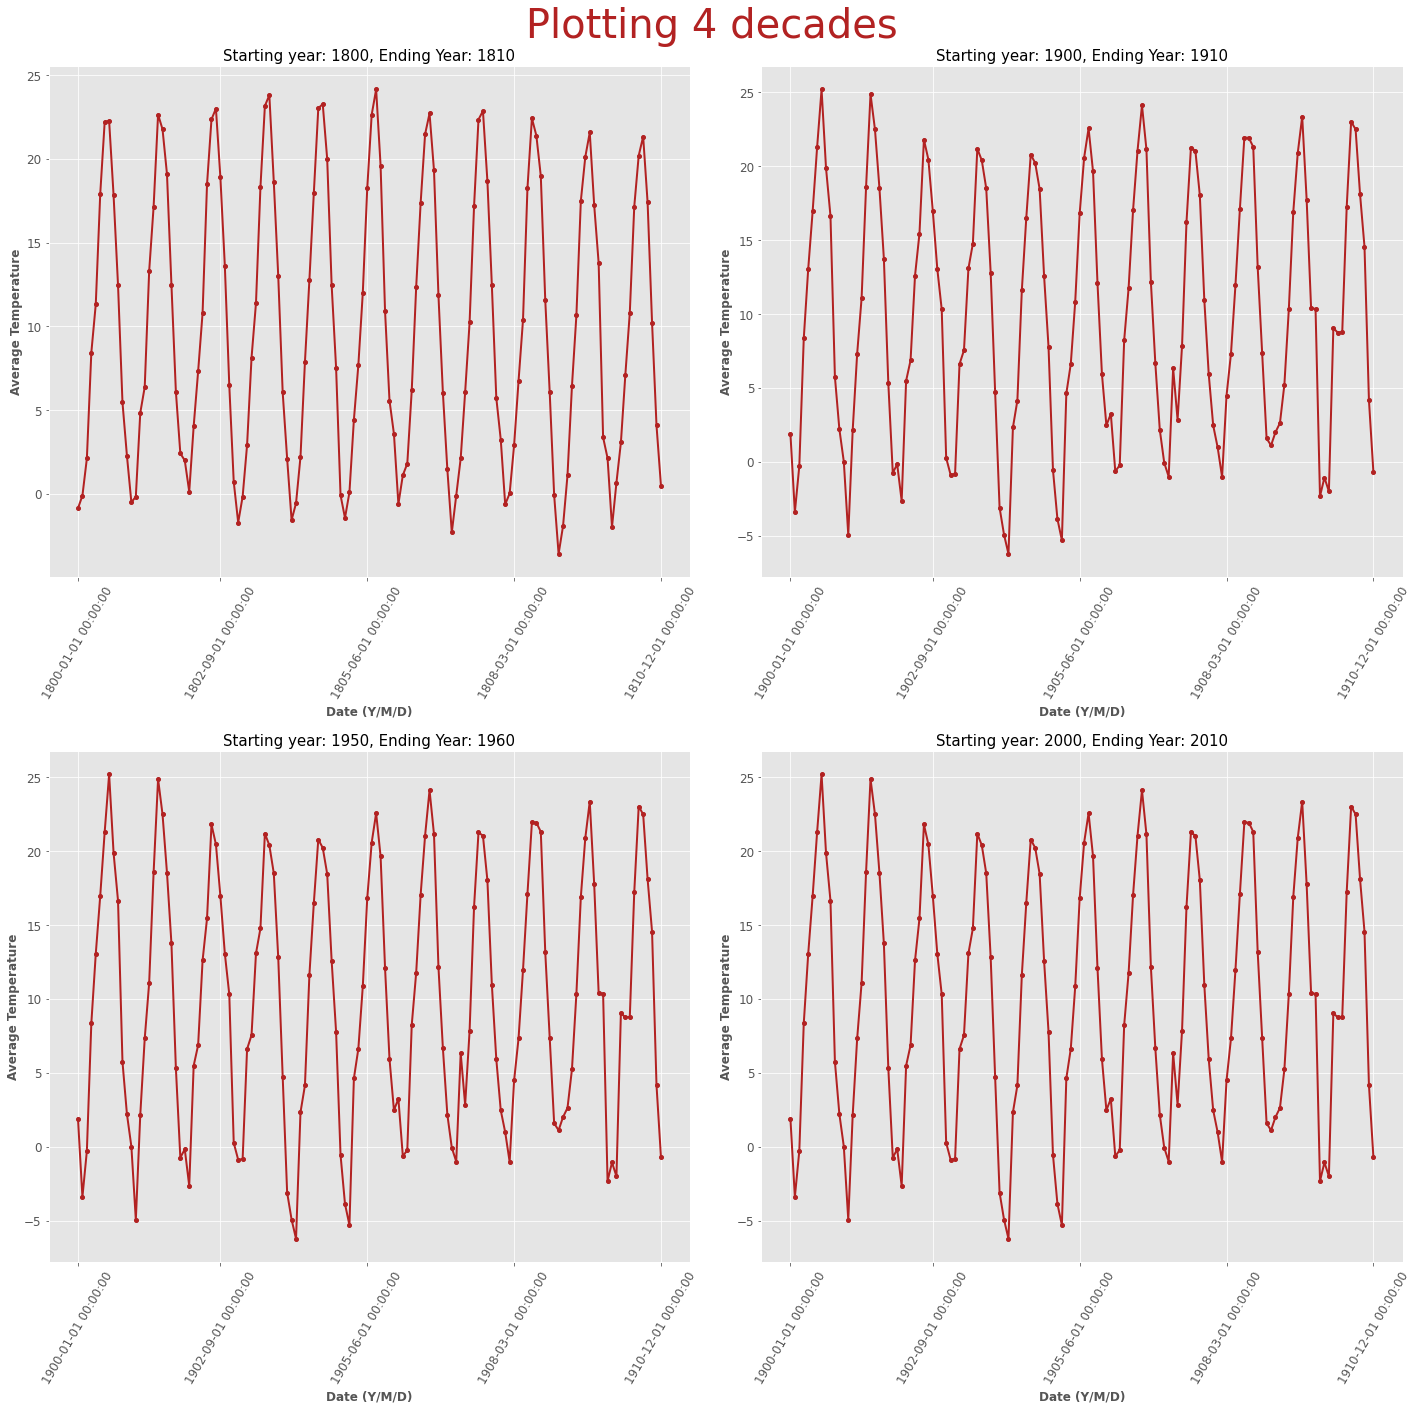

In [54]:
plt.figure(figsize=(20,20))
plt.suptitle('Plotting 4 decades',fontsize=40,color='firebrick')

plt.subplot(2,2,1)
plt.title('Starting year: 1800, Ending Year: 1810',fontsize=15)
plot_timeseries(1800,1810)
plt.subplot(2,2,2)
plt.title('Starting year: 1900, Ending Year: 1910',fontsize=15)
plot_timeseries(1900,1910)
plt.subplot(2,2,3)
plt.title('Starting year: 1950, Ending Year: 1960',fontsize=15)
plot_timeseries(1900,1910)
plt.subplot(2,2,4)
plt.title('Starting year: 2000, Ending Year: 2010',fontsize=15)
plot_timeseries(1900,1910)
plt.tight_layout()

(2.0, 22.0)

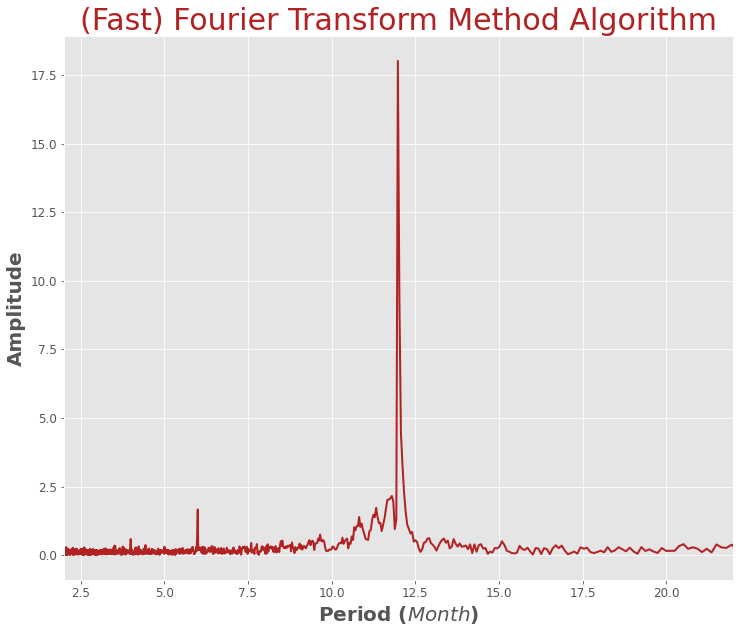

In [55]:
FFT = np.fft.fft(chicago_data.AverageTemperature)
FFT_abs = np.abs(FFT)
new_N=int(len(FFT)/2) 
f_nat=1
new_X = np.linspace(0, f_nat/2, new_N, endpoint=True)
new_X = 1/new_X
plt.plot(new_X,2*FFT_abs[0:int(len(FFT)/2.)]/len(new_X),color='firebrick')
plt.xlabel('Period ($Month$)',fontsize=20)
plt.ylabel('Amplitude',fontsize=20)
plt.title('(Fast) Fourier Transform Method Algorithm',fontsize=30,color='firebrick')
plt.grid(True)
plt.xlim(2,22)

In [56]:
# Checking on Stationarity

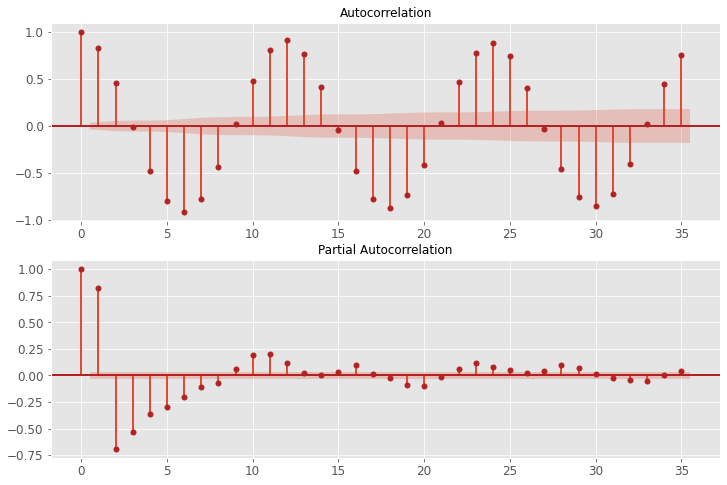

In [57]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(chicago_data.AverageTemperature, ax=ax1,color ='firebrick')
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(chicago_data.AverageTemperature, ax=ax2,color='firebrick')

ADF Statistic on the entire dataset: -6.136682572298666
p-value: 8.155104183671404e-08
Critical Values:
	1%: -3.4324530533936075
	5%: -2.8624691981601122
	10%: -2.5672646345228025
ADF Statistic on the first decade: -7.21177190805288
p-value: 2.2252528032788746e-10
Critical Values:
	1%: -3.489057523907491
	5%: -2.887246327182993
	10%: -2.5804808802708528


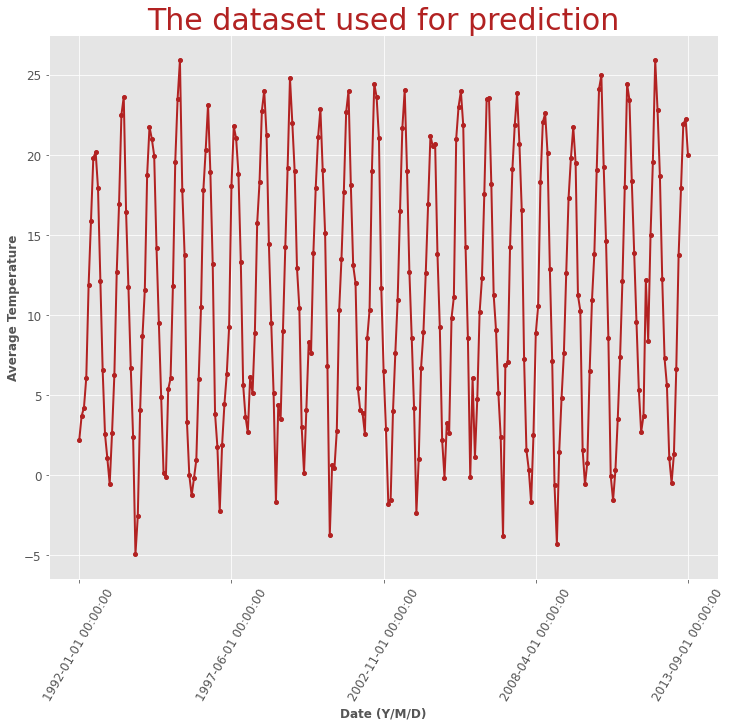

In [62]:
result = adfuller(chicago_data.AverageTemperature)
print('ADF Statistic on the entire dataset: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))
    
result = adfuller(chicago_data.AverageTemperature[0:120])
print('ADF Statistic on the first decade: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))
plt.title('The dataset used for prediction', fontsize=30,color='firebrick')
plot_timeseries(1992,2013)

In [63]:
temp = get_timeseries(1992,2013)
N = len(temp.AverageTemperature)
split = 0.95
training_size = round(split*N)
test_size = round((1-split)*N)
series = temp.AverageTemperature[:training_size]
date = temp.dt[:training_size]
test_series = temp.AverageTemperature[len(date)-1:len(temp)]
test_date = temp.dt[len(date)-1:len(temp)]

In [64]:
test_date

247   2012-08-01
248   2012-09-01
249   2012-10-01
250   2012-11-01
251   2012-12-01
252   2013-01-01
253   2013-02-01
254   2013-03-01
255   2013-04-01
256   2013-05-01
257   2013-06-01
258   2013-07-01
259   2013-08-01
260   2013-09-01
Name: dt, dtype: datetime64[ns]

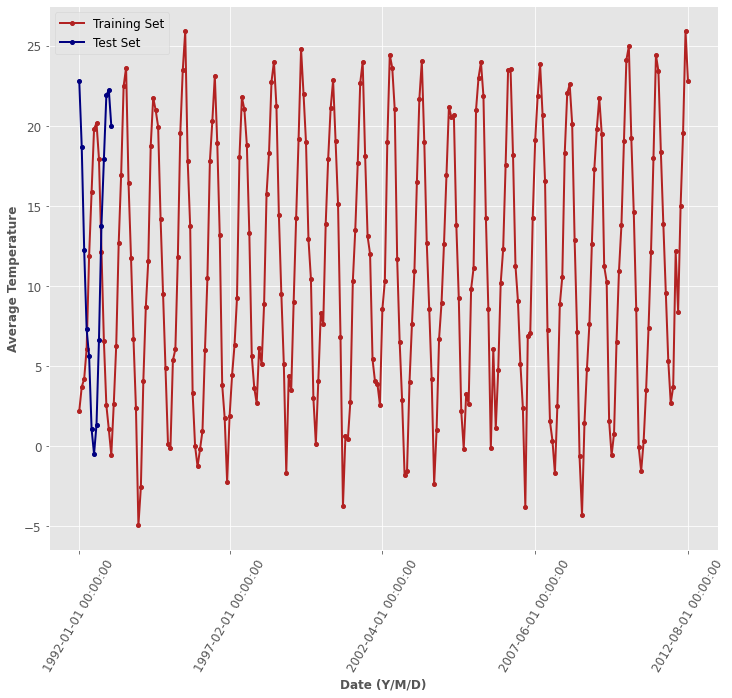

In [65]:
plot_from_data(series,date,label='Training Set')
plot_from_data(test_series,test_date,'navy',with_ticks=False,label='Test Set')
plt.legend()

In [66]:
def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        #try: 
        model = SARIMAX(exog, order=order).fit(disp=-1)
    #except:
    #        continue
            
        aic = model.aic
        results.append([order, model.aic])
    #print(results)
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [67]:
ps = range(0, 10, 1)
d = 0
qs = range(0, 10, 1)

In [ ]:
# Create a list with all possible combination of parameters

In [68]:
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)

In [69]:
result_d_0 = optimize_ARIMA(order_list, exog = series)

  0%|          | 0/100 [00:00<?, ?it/s]

In [71]:
result_d_0.head()
ps = range(0, 10, 1)
d = 1
qs = range(0, 10, 1)

In [72]:
# Create a list with all possible combination of parameters

In [70]:
parameters = product(ps, qs)
parameters_list = list(parameters)

order_list = []

for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)

In [73]:
result_d_1 = optimize_ARIMA(order_list, exog = series)

result_d_1

  0%|          | 0/100 [00:00<?, ?it/s]

,"(p, d, q)",AIC
0,"(4, 0, 6)",1097.422496
1,"(4, 0, 5)",1098.111187
2,"(5, 0, 6)",1098.198213
3,"(3, 0, 5)",1098.243459
4,"(5, 0, 7)",1098.247954
...,...,...
95,"(1, 0, 0)",1480.180356
96,"(0, 0, 3)",1490.466700
97,"(0, 0, 2)",1584.824072
98,"(0, 0, 1)",1744.062269


In [74]:
result_d_1.head()
final_result = result_d_0.append(result_d_1)
best_models = final_result.sort_values(by='AIC', ascending=True).reset_index(drop=True).head()
best_model_params_0 = best_models[best_models.columns[0]][0]
best_model_params_1 = best_models[best_models.columns[0]][1]
best_model_0 = SARIMAX(series, order=best_model_params_0).fit()
print(best_model_0.summary())
best_model_1 = SARIMAX(series, order=best_model_params_1).fit()
print(best_model_1.summary())

                               SARIMAX Results                                
Dep. Variable:     AverageTemperature   No. Observations:                  248
Model:               SARIMAX(4, 0, 6)   Log Likelihood                -537.711
Date:                Tue, 17 Jan 2023   AIC                           1097.422
Time:                        17:29:45   BIC                           1136.070
Sample:                             0   HQIC                          1112.981
                                - 248                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7386      0.100     17.339      0.000       1.542       1.935
ar.L2         -0.0180      0.274     -0.066      0.948      -0.555       0.519
ar.L3         -1.7139      0.274     -6.260      0.0

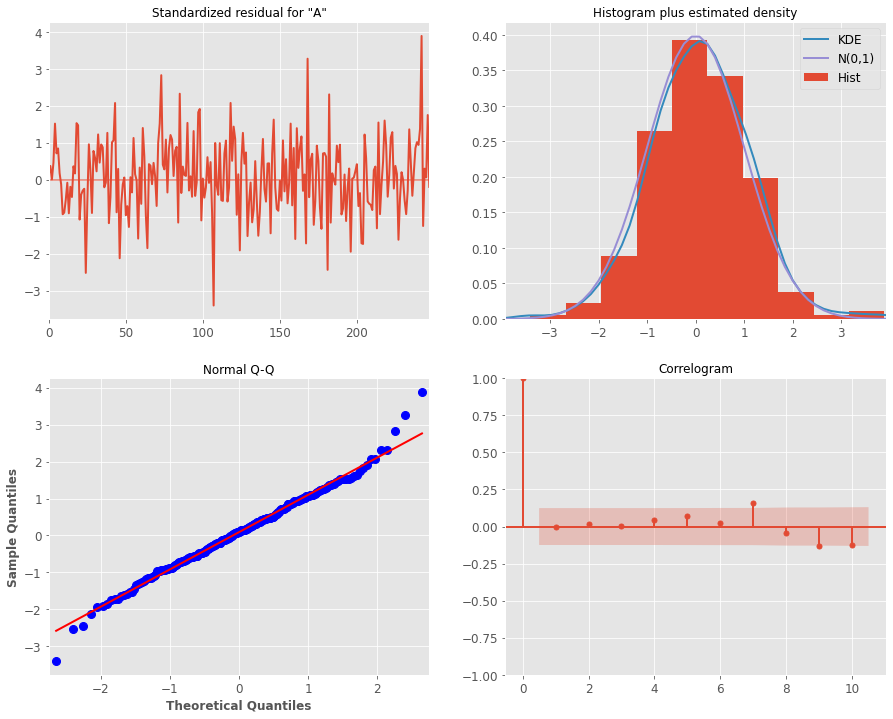

In [79]:
best_model_1.plot_diagnostics(figsize=(15,12))
plt.show()

In [ ]:
# Forecasting

In [77]:
fore_l= test_size-1
forecast = best_model_0.get_prediction(start=training_size, end=training_size+fore_l)
forec = forecast.predicted_mean
ci = forecast.conf_int(alpha=0.05)

s_forecast = best_model_1.get_prediction(start=training_size, end=training_size+fore_l)
s_forec = s_forecast.predicted_mean
s_ci = forecast.conf_int(alpha=0.05)

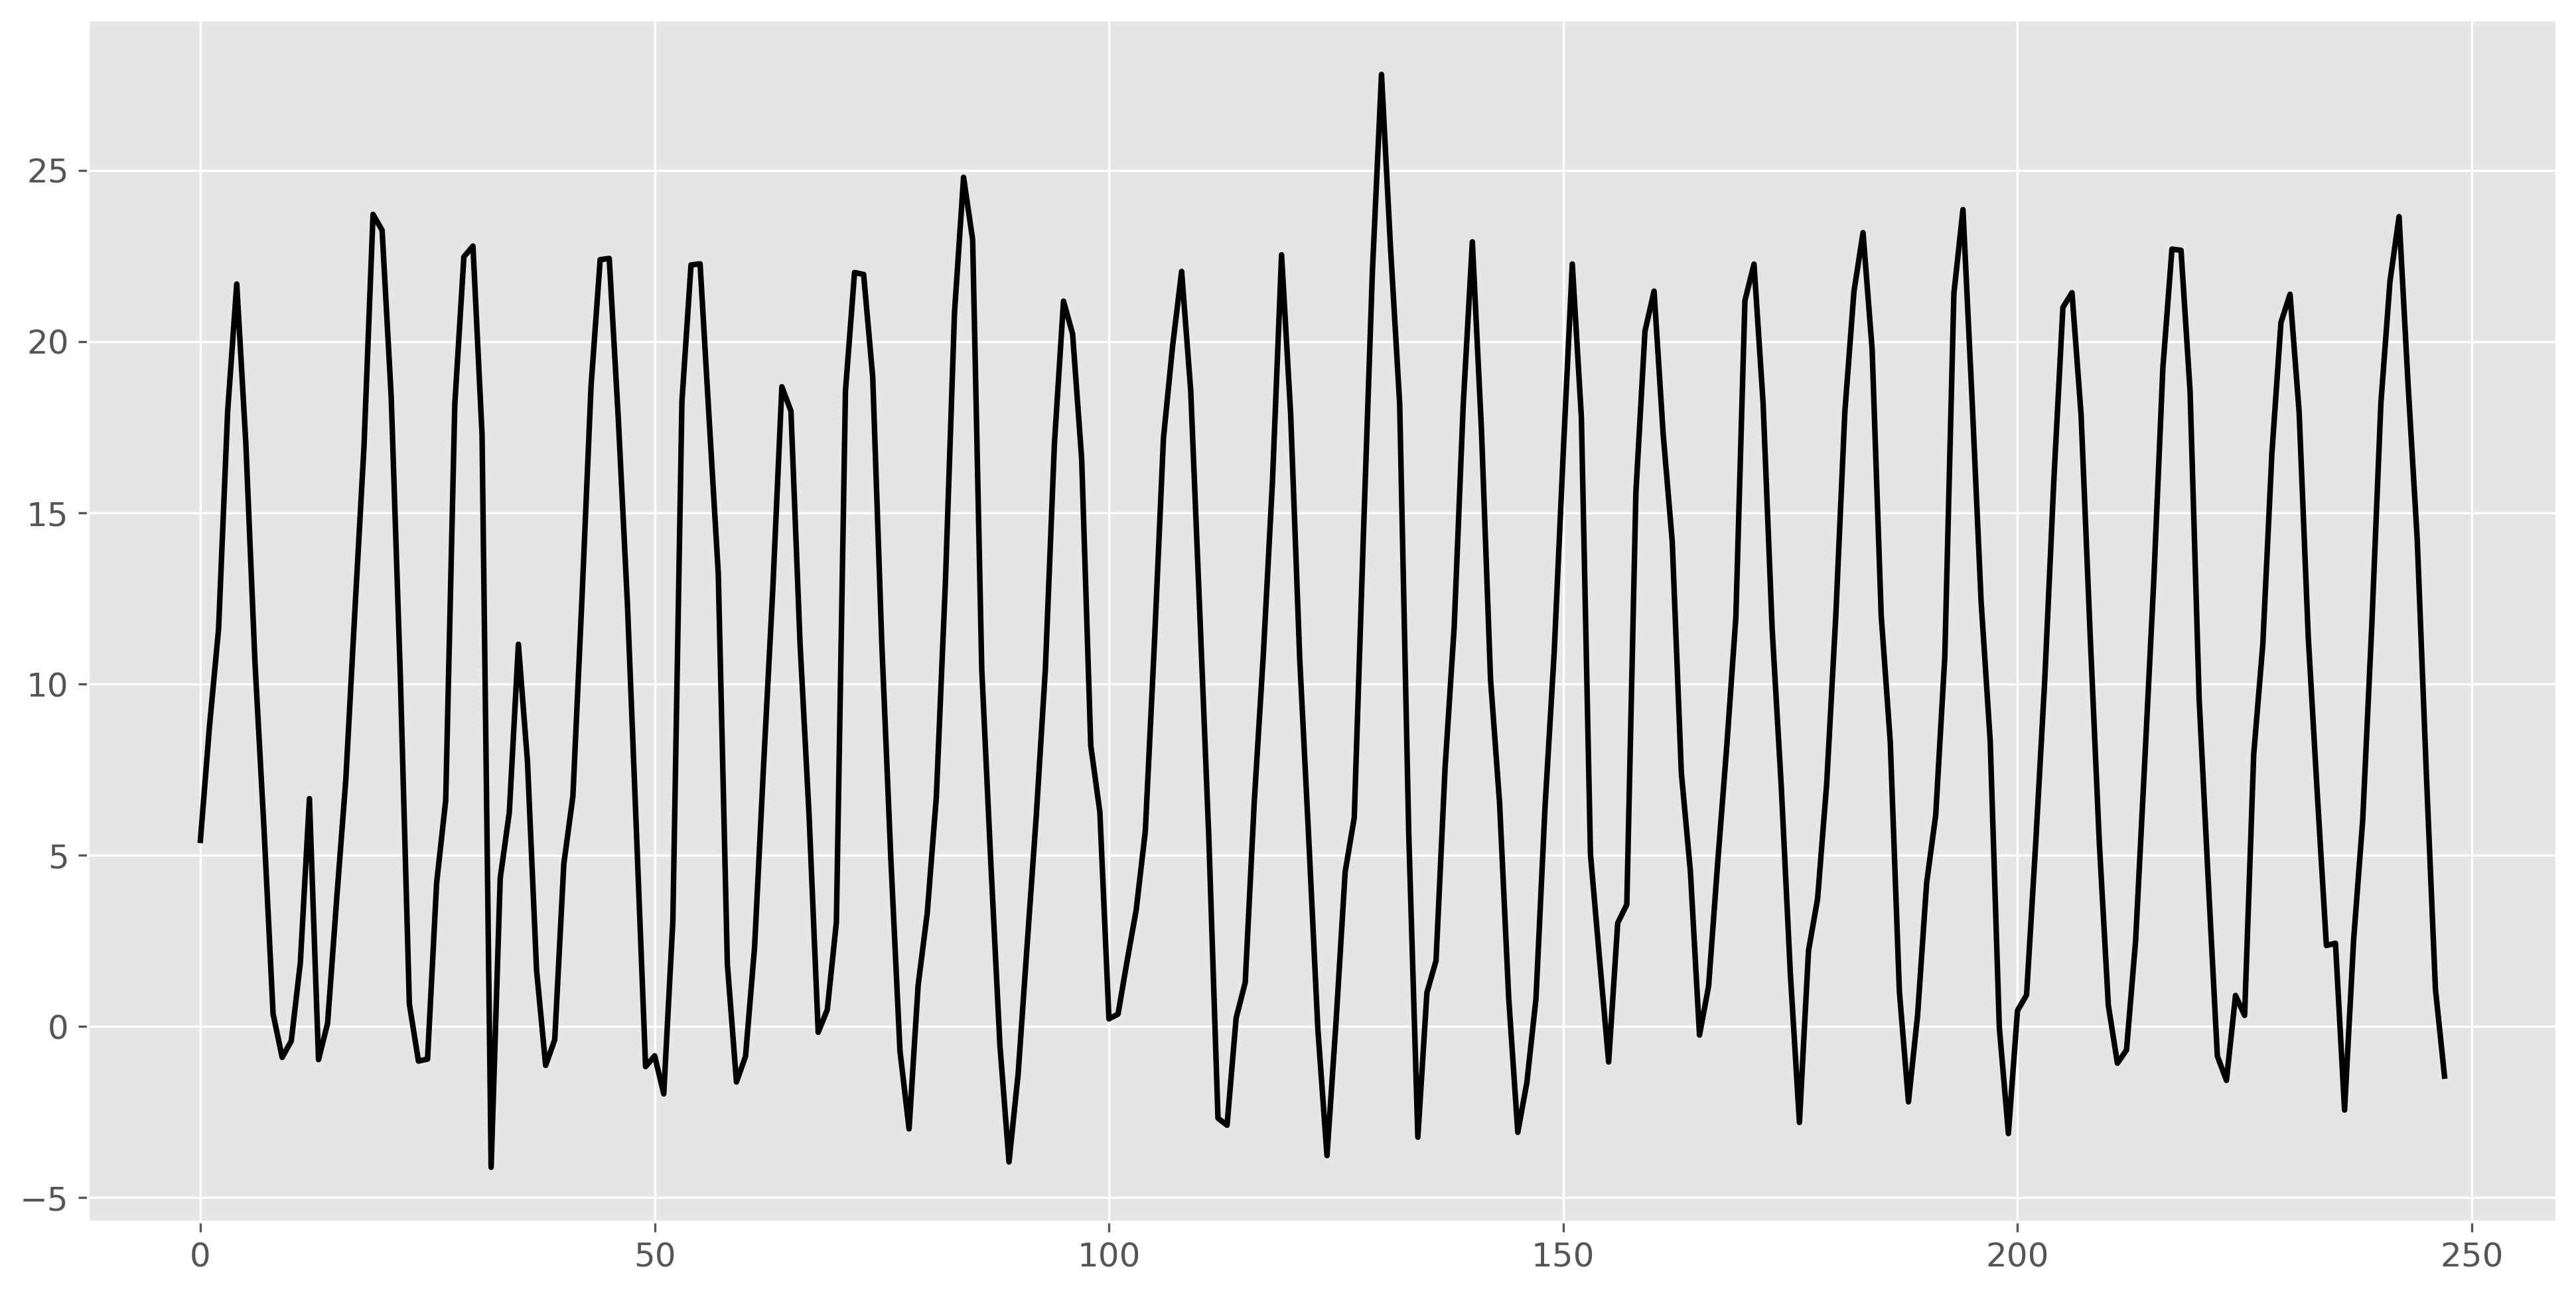

In [80]:
error_test=chicago_data.loc[test_date[1:].index.tolist()].AverageTemperatureUncertainty
index_test = test_date[1:].index.tolist()
test_set = test_series[1:]
lower_test = test_set-error_test
upper_test = test_set+error_test
fig, ax = plt.subplots(figsize=(16,8), dpi=300)
x0 = chicago_data.AverageTemperature.index[0:training_size]
x1=chicago_data.AverageTemperature.index[training_size:training_size+fore_l+1]
#ax.fill_between(forec, ci['lower Load'], ci['upper Load'])
plt.plot(x0, chicago_data.AverageTemperature[0:training_size],'k', label = 'Average Temperature')

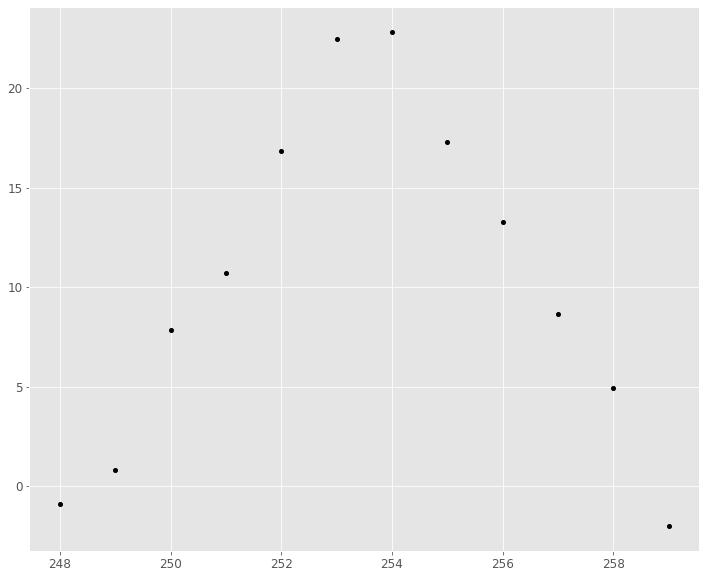

In [82]:
plt.plot(chicago_data.AverageTemperature[training_size:training_size+fore_l], '.k', label = 'Actual')


In [102]:
forec = pd.DataFrame(forec, columns=['f'], index = x1)
#forec.f.plot(ax=ax,color = 'Darkorange',label = 'Forecast (d = 2)')
#ax.fill_between(x1, ci['lower AverageTemperature'], ci['upper AverageTemperature'],alpha=0.2, label = 'Confidence inerval (95%)',color='grey')
s_forec = pd.DataFrame(s_forec, columns=['f'], index = x1)
s_forec.f.plot(ax=ax,color = 'firebrick',label = 'Forecast  (2,1,6) model')
ax.fill_between(x1, s_ci['lower AverageTemperature'], s_ci['upper AverageTemperature'],alpha=0.2, label = 'Confidence inerval (95%)',color='grey')

Text(0, 0.5, 'Temperature')

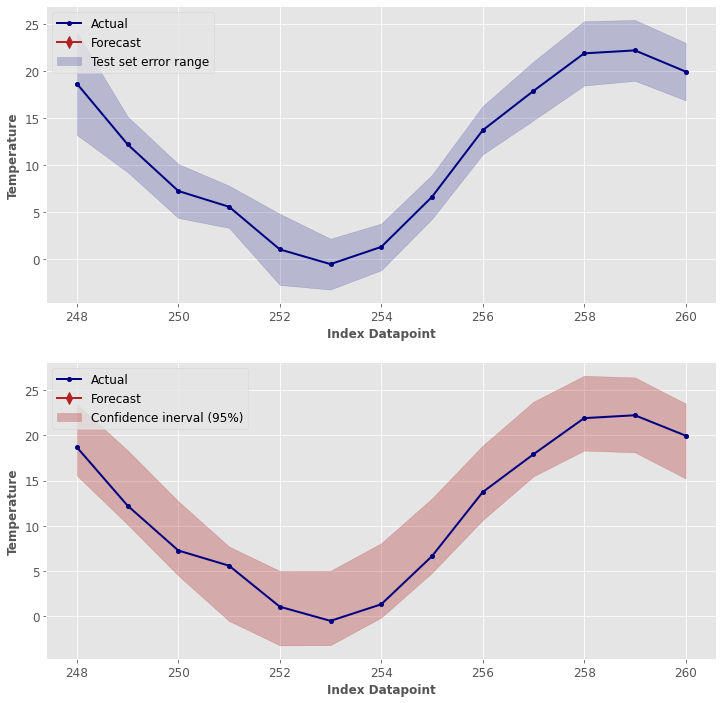

In [105]:
#plt.plot(forec)
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
plt.fill_between(x1, lower_test, upper_test,alpha=0.2, label = 'Test set error range',color='navy')
plt.plot(test_set,marker='.',label="Actual",color='navy')
plt.plot(forec,marker='d',label="Forecast",color='firebrick')
plt.xlabel('Index Datapoint')
plt.ylabel('Temperature')
#plt.fill_between(x1, s_ci['lower AverageTemperature'], s_ci['upper AverageTemperature'],alpha=0.3, label = 'Confidence inerval (95%)',color='firebrick')
plt.legend()
plt.subplot(2,1,2)
#plt.fill_between(x1, lower_test, upper_test,alpha=0.2, label = 'Test set error range',color='navy')
plt.plot(test_set,marker='.',label="Actual",color='navy')
plt.plot(s_forec,marker='d',label="Forecast",color='firebrick')
plt.fill_between(x1, ci['lower AverageTemperature'], ci['upper AverageTemperature'],alpha=0.3, label = 'Confidence inerval (95%)',color='firebrick')
plt.legend()
plt.xlabel('Index Datapoint')
plt.ylabel('Temperature')

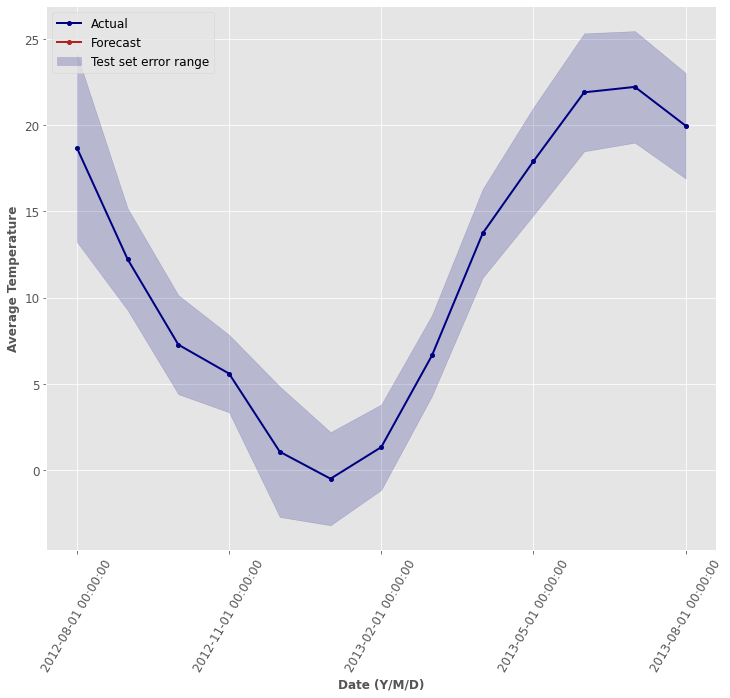

In [106]:
plt.fill_between(np.arange(0,len(test_set),1), lower_test, upper_test,alpha=0.2, label = 'Test set error range',color='navy')
plot_from_data(test_set,test_date,c='navy',label='Actual')
plot_from_data(forec['f'],test_date,c='firebrick',label='Forecast')
plt.legend(loc=2)